<img src = "https://raw.githubusercontent.com/barcelonagse-datascience/academic_files/master/images/BSE_DSC_HEADER.jpg">

# Project 2: Decision trees, Ensembles and Neural Networks
### Catalina Odizzio

In [130]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import random 

import datetime as dt
from datetime import timedelta

from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, cross_val_score, HalvingGridSearchCV
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import  mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

from xgboost import XGBRegressor
from mlens.ensemble import SuperLearner

from category_encoders import TargetEncoder
from category_encoders.cat_boost import CatBoostEncoder

import pickle
from itertools import combinations

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import regularizers

from skopt import BayesSearchCV

import utils
from utils.helper_functions import *

import warnings
warnings.filterwarnings("ignore")

### 1.1. Loading Data

In [131]:
# Training dataset
df_train = pd.read_csv("mimic_train.csv")
df_train.head()

HOSPITAL_EXPIRE_FLAG  subject_id  hadm_id  icustay_id  HeartRate_Min  \
0                     0       55440   195768      228357           89.0   
1                     0       76908   126136      221004           63.0   
2                     0       95798   136645      296315           81.0   
3                     0       40708   102505      245557           76.0   
4                     0       28424   127337      225281            NaN   

   HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  ...  \
0          145.0      121.043478       74.0      127.0  106.586957  ...   
1          110.0       79.117647       89.0      121.0  106.733333  ...   
2           98.0       91.689655       88.0      138.0  112.785714  ...   
3          128.0       98.857143       84.0      135.0  106.972973  ...   
4            NaN             NaN        NaN        NaN         NaN  ...   

          Diff  ADMISSION_TYPE  INSURANCE           RELIGION  MARITAL_STATUS  \
0 -61961.78470       EMERGENCY   Medicare  PROTESTANT QUAKER          SINGLE   
1 -43146.18378       EMERGENCY    Private       UNOBTAINABLE         MARRIED   
2 -42009.96157       EMERGENCY   Medicare  PROTESTANT QUAKER       SEPARATED   
3 -43585.37922        ELECTIVE   Medicare      NOT SPECIFIED         WIDOWED   
4 -50271.76602       EMERGENCY   Medicare             JEWISH         WIDOWED   

                ETHNICITY                  DIAGNOSIS  ICD9_diagnosis  \
0                   WHITE     GASTROINTESTINAL BLEED            5789   
1                   WHITE  ESOPHAGEAL FOOD IMPACTION           53013   
2  BLACK/AFRICAN AMERICAN             UPPER GI BLEED           56983   
3                   WHITE          HIATAL HERNIA/SDA            5533   
4                   WHITE             ABDOMINAL PAIN           56211   

   FIRST_CAREUNIT     LOS  
0            MICU  4.5761  
1            MICU  0.7582  
2            MICU  3.7626  
3            SICU  3.8734  
4           TSICU  5.8654  

[5 rows x 41 columns]

In [132]:
# Test dataset (to produce predictions)
df_test = pd.read_csv("mimic_test_los.csv")
df_test.head()

subject_id  hadm_id  icustay_id  HeartRate_Min  HeartRate_Max  \
0       64058   146725      208169           58.0           90.0   
1       55871   108789      251754           91.0          145.0   
2       42892   139885      242171          106.0          132.0   
3       66629   173017      263035           72.0          105.0   
4       79851   171573      279388           85.0          124.0   

   HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  DiasBP_Min  ...  \
0       85.244898       77.0      153.0   98.490909        40.0  ...   
1      115.055556       73.0      143.0  101.210526        42.0  ...   
2      117.750000       93.0      137.0  116.222222        51.0  ...   
3       83.627119       72.0      168.0  126.981818        39.0  ...   
4       98.600000       86.0      144.0  110.666667        52.0  ...   

             ADMITTIME         Diff  ADMISSION_TYPE  INSURANCE       RELIGION  \
0  2196-02-23 11:45:00 -67454.42740        ELECTIVE   Medicare       CATHOLIC   
1  2103-10-22 23:58:00 -34204.08546       EMERGENCY    Private  NOT SPECIFIED   
2  2115-06-28 07:15:00 -38710.61714        ELECTIVE   Medicare       CATHOLIC   
3  2162-08-01 21:00:00 -54902.54313       EMERGENCY    Private   EPISCOPALIAN   
4  2103-01-16 22:05:00 -33906.93488       EMERGENCY   Medicare       CATHOLIC   

   MARITAL_STATUS  ETHNICITY  \
0         MARRIED      WHITE   
1         MARRIED      WHITE   
2         MARRIED      WHITE   
3         WIDOWED      WHITE   
4          SINGLE      WHITE   

                                           DIAGNOSIS  ICD9_diagnosis  \
0  AORTIC STENOSIS\CORONARY ARTERY BYPASS GRAFT W...            4241   
1                                      HYPERGLYCEMIA           25013   
2                                  KIDNEY STONES/SDA            5920   
3                               RIGHT FEMUR FRACTURE           82120   
4                         PNEUMONIA;RAPID AF;HYPOXIA           51884   

   FIRST_CAREUNIT  
0            CSRU  
1            MICU  
2            MICU  
3             CCU  
4            MICU  

[5 rows x 39 columns]

In [133]:
#Diagnosis extra data
extra = pd.read_csv('MIMIC_diagnoses.csv')
extra.columns = [x.lower() for x in extra.columns]
extra.head()

subject_id  hadm_id  seq_num icd9_code
0         256   108811      1.0     53240
1         256   108811      2.0     41071
2         256   108811      3.0     53560
3         256   108811      4.0     40390
4         256   108811      5.0      5859

In [134]:
diagnosis = pd.read_csv('MIMIC_metadata_diagnose.csv')
diagnosis.columns = [x.lower() for x in diagnosis.columns]
diagnosis.head()

icd9_code short_diagnose                                    long_diagnose
0       436            Cva  Acute, but ill-defined, cerebrovascular disease
1     78001           Coma                                             Coma
2     E0062           Golf                        Activities involving golf
3      0460           Kuru                                             Kuru
4     30752           Pica                                             Pica

### 2. Exploratory Data Analysis
#### 2.1. Data types


In [135]:
#Data types
print(df_train.dtypes); print('\n')
print(df_test.dtypes)

HOSPITAL_EXPIRE_FLAG      int64
subject_id                int64
hadm_id                   int64
icustay_id                int64
HeartRate_Min           float64
HeartRate_Max           float64
HeartRate_Mean          float64
SysBP_Min               float64
SysBP_Max               float64
SysBP_Mean              float64
DiasBP_Min              float64
DiasBP_Max              float64
DiasBP_Mean             float64
MeanBP_Min              float64
MeanBP_Max              float64
MeanBP_Mean             float64
RespRate_Min            float64
RespRate_Max            float64
RespRate_Mean           float64
TempC_Min               float64
TempC_Max               float64
TempC_Mean              float64
SpO2_Min                float64
SpO2_Max                float64
SpO2_Mean               float64
Glucose_Min             float64
Glucose_Max             float64
Glucose_Mean            float64
GENDER                   object
DOB                      object
ADMITTIME                object
Diff    

#### 2.2. Variables analysis


In [136]:
df_train.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'ADMITTIME', 'Diff', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'LOS'],
      dtype='object')

In [137]:
#Numerical and non_numerical variables
num_var = ['HeartRate_Min', 'HeartRate_Max','HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean','RespRate_Min', 'RespRate_Max',
        'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'Diff', 'LOS']

non_num_var = ['GENDER', 'DOB','ADMITTIME', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
        'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis','FIRST_CAREUNIT']

#### 2.2.1. Numerical variables


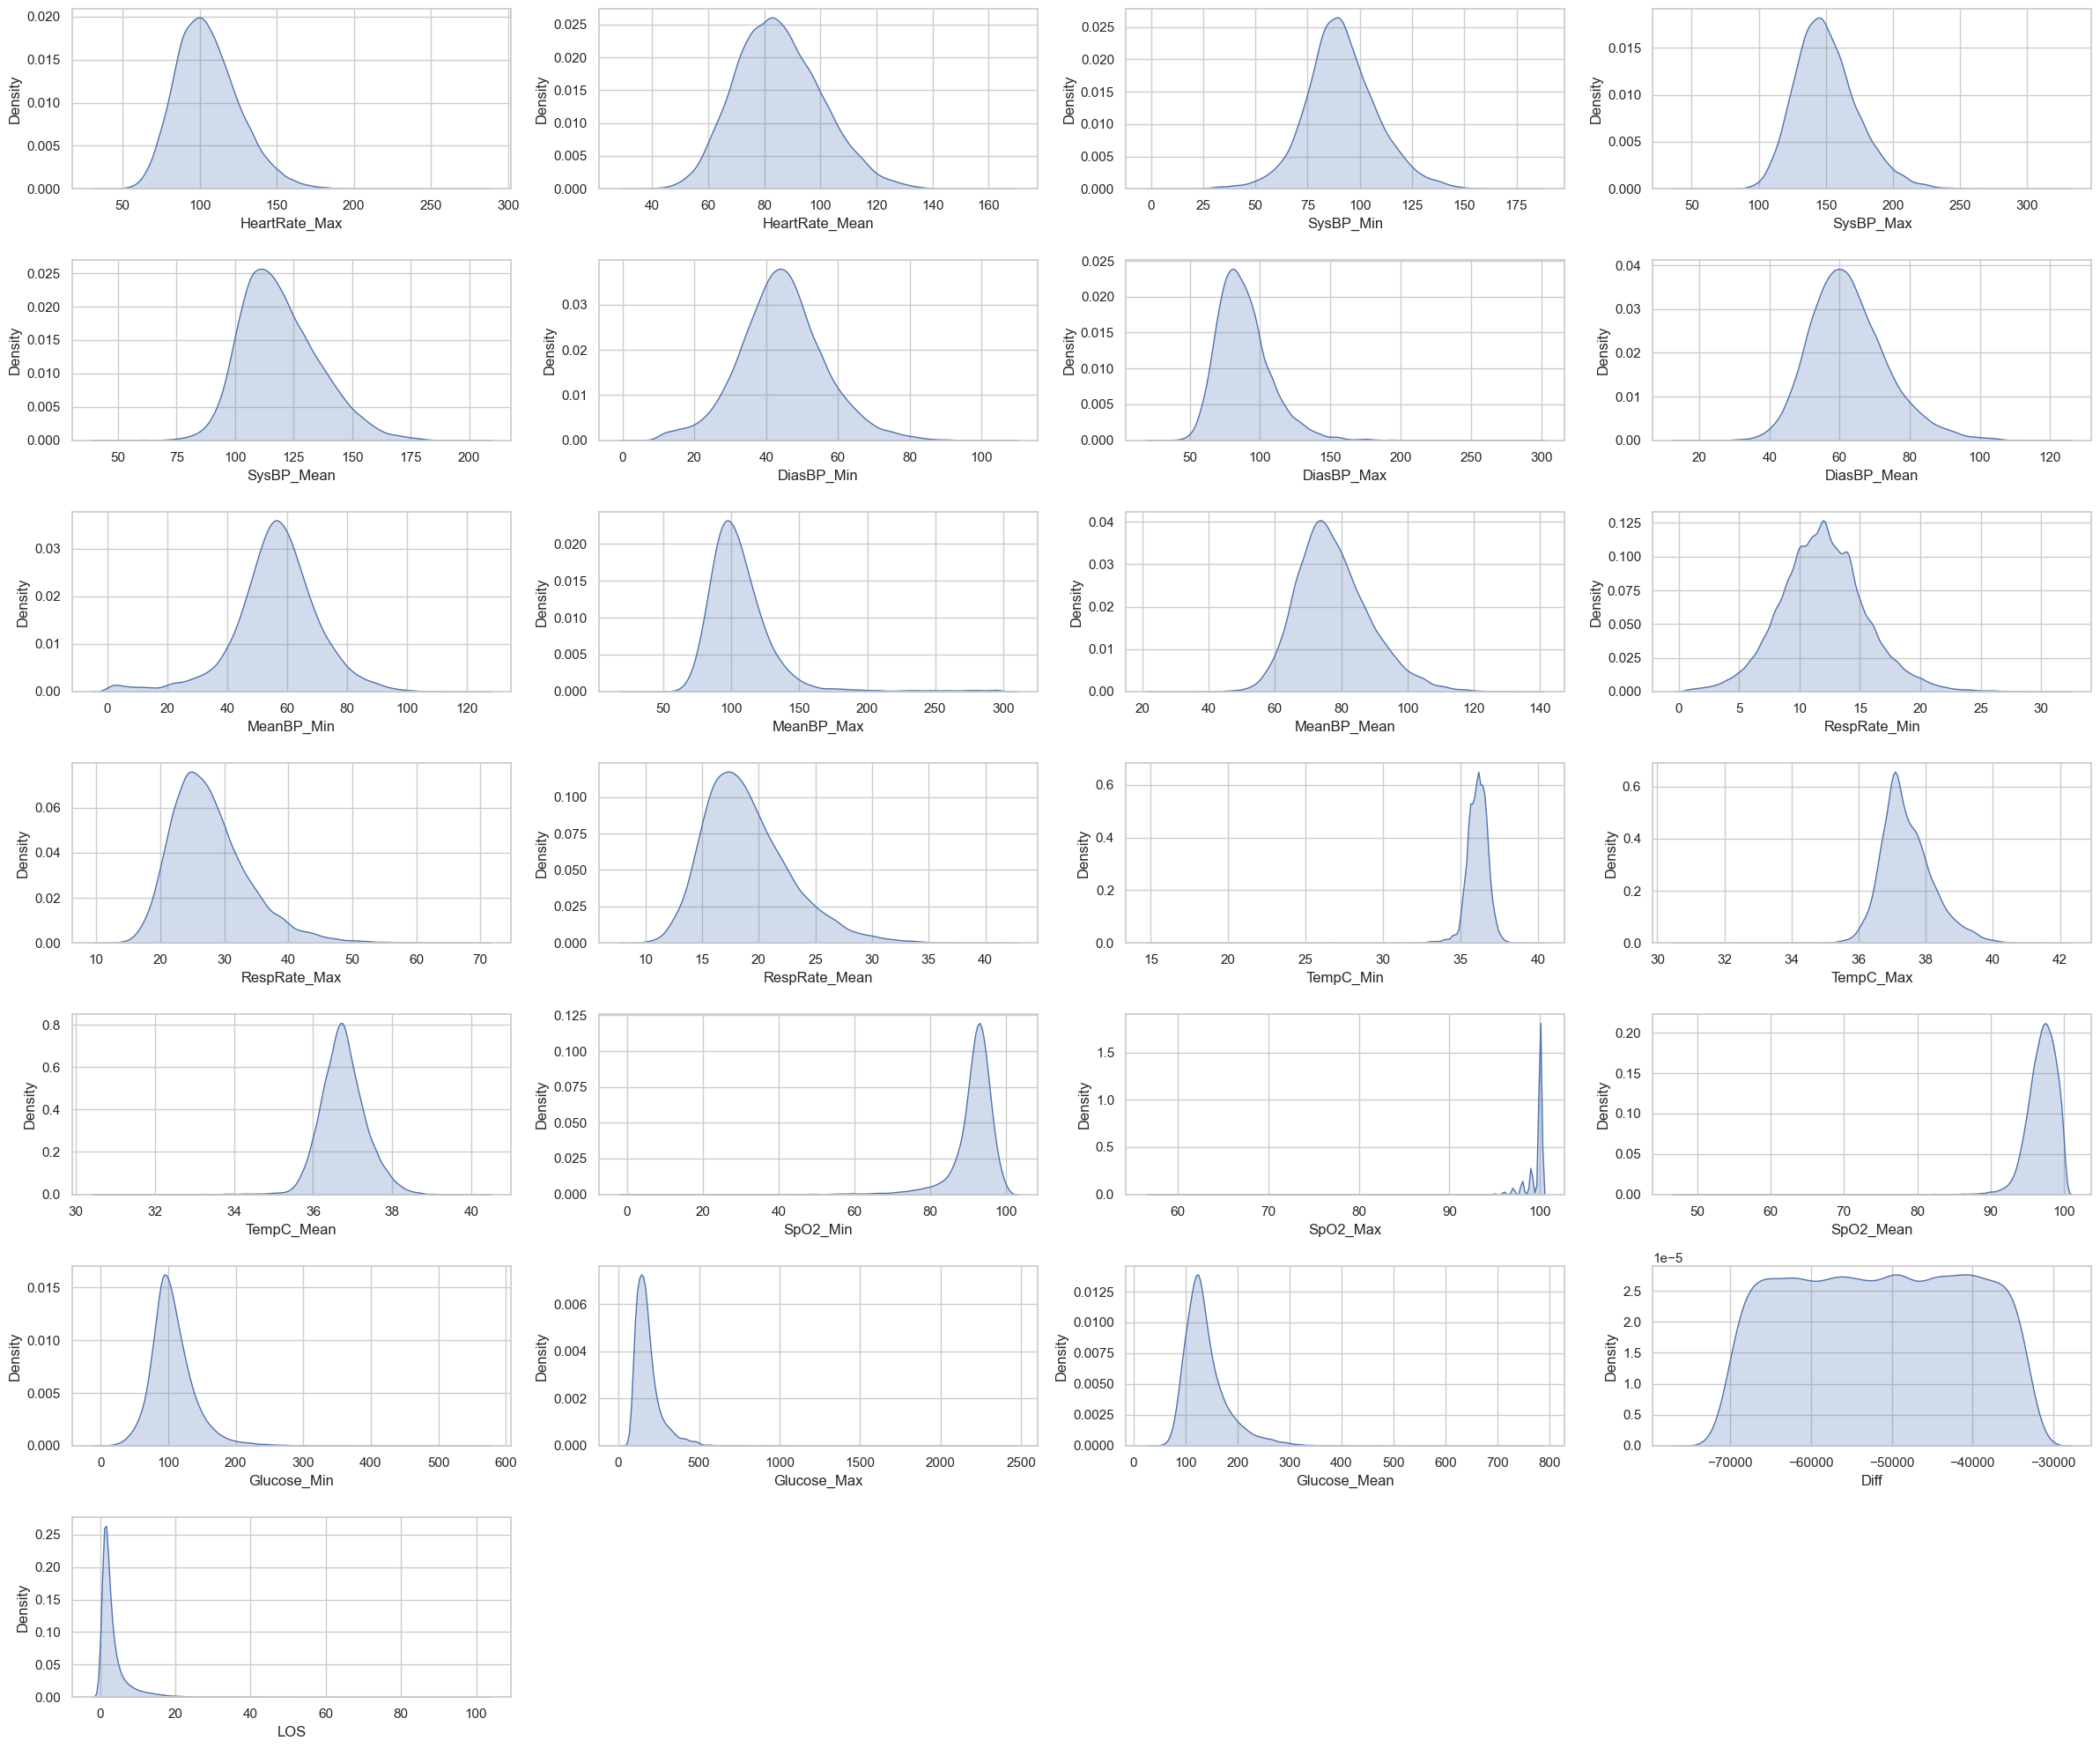

In [138]:
# Univariate kernel density distributions for numeric variables

sns.set(style="whitegrid")
plt.figure(figsize=(24, 20))

for n, col in enumerate(num_var):
  if n == 0:
    pass
  else:
    plt.subplot(7, 4, n)
    sns.kdeplot(x = col, 
                data = df_train, 
                fill=True)
plt.tight_layout()

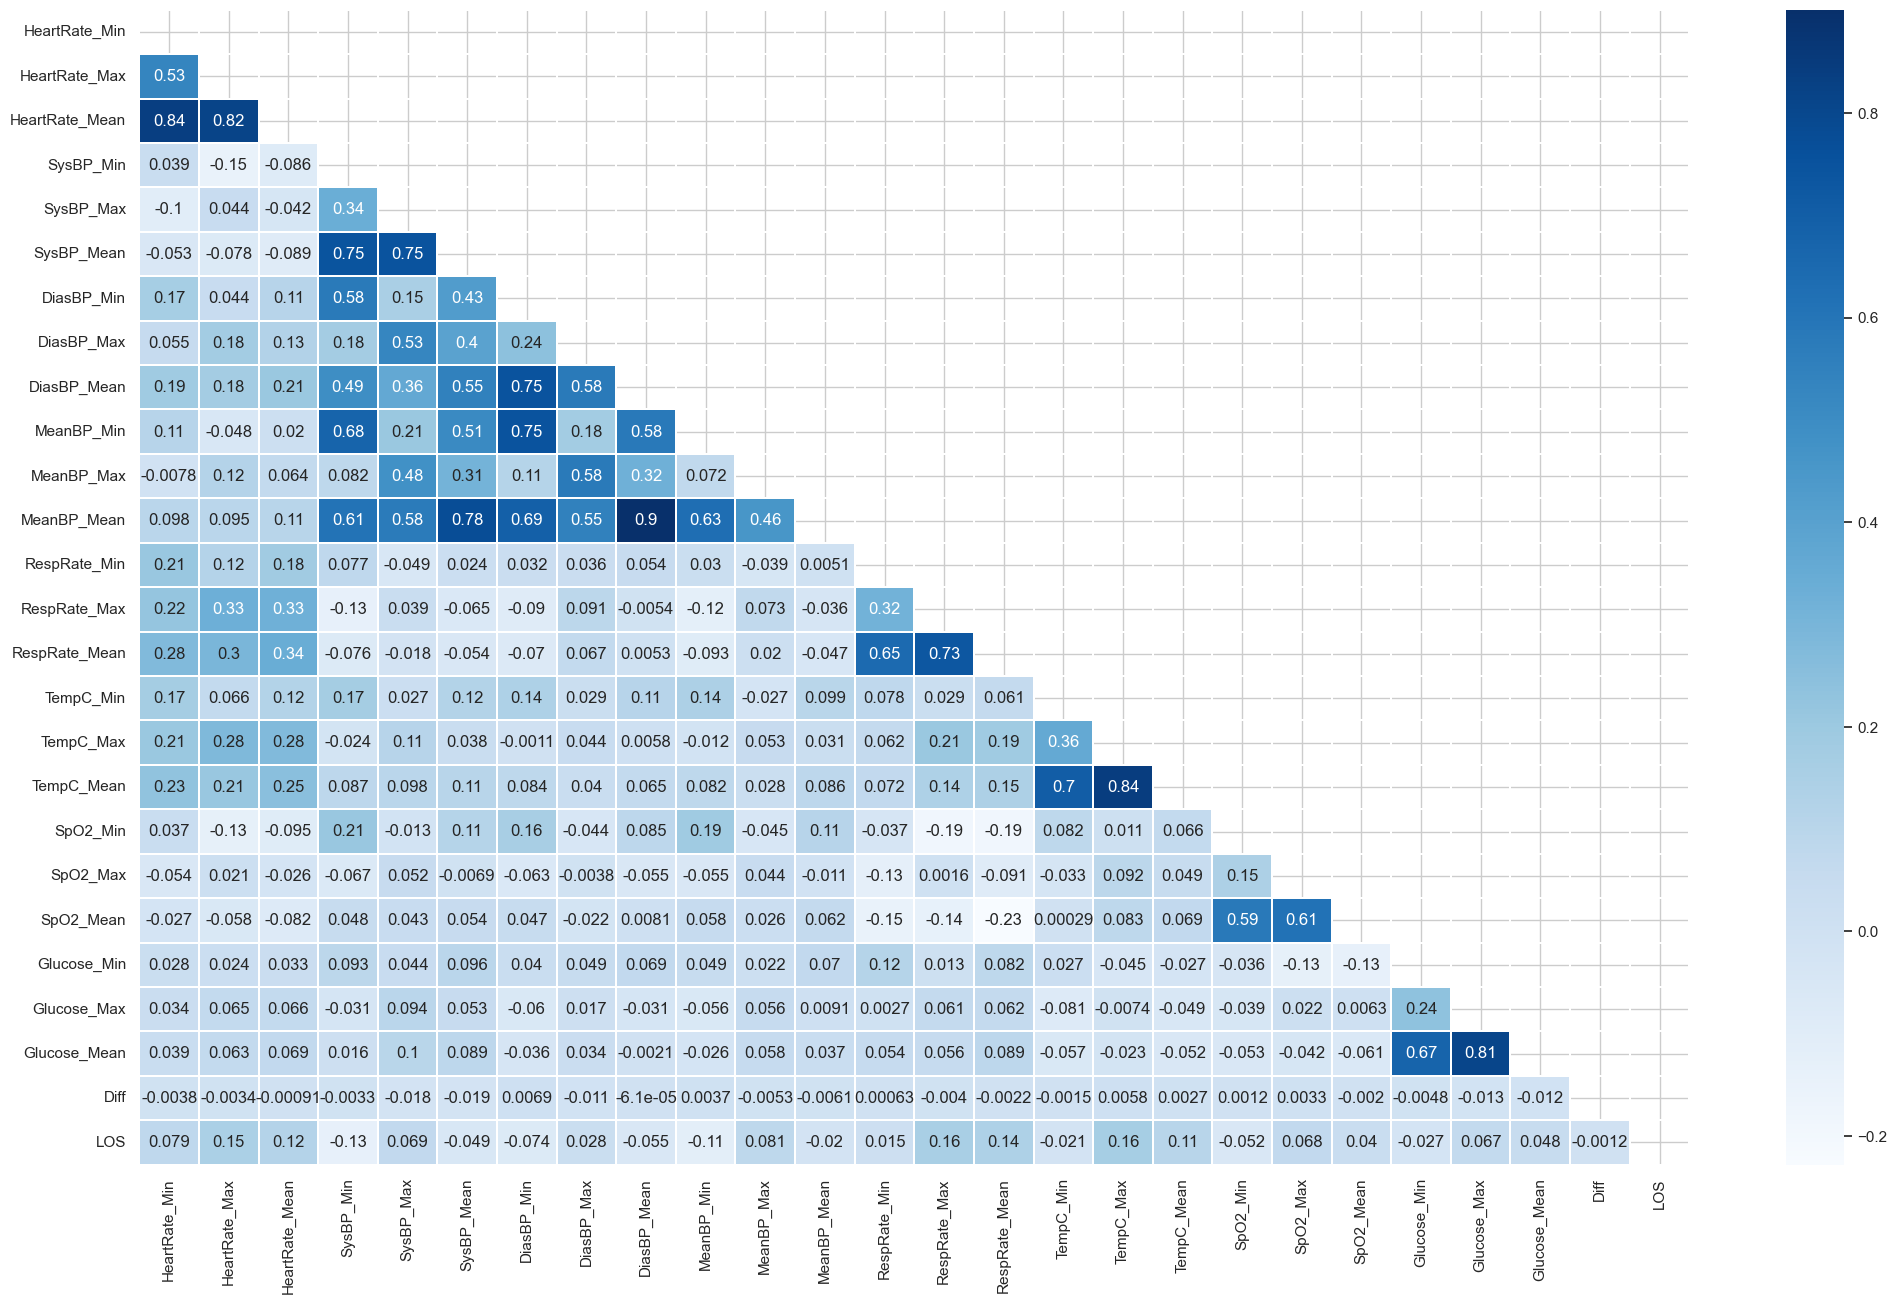

In [139]:
# Correlation matrix between features

df_corr = df_train[num_var].corr()

fig, ax = plt.subplots(figsize=(25,15))
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(df_corr, mask = mask, annot = True, linewidths=0.1, linecolor='white', 
                 cmap=sns.color_palette("Blues", as_cmap=True))


In this matrix, it can be observed that certain variables, such as those related to patients' vital signs, are highly correlated.

In [140]:
# Correlation with target variable

corr_matrix = df_train[num_var].corr()
corr_matrix["LOS"].sort_values(ascending=False)

LOS               1.000000
TempC_Max         0.164657
RespRate_Max      0.159270
HeartRate_Max     0.150670
RespRate_Mean     0.141701
HeartRate_Mean    0.116884
TempC_Mean        0.106119
MeanBP_Max        0.081008
HeartRate_Min     0.079271
SysBP_Max         0.068940
SpO2_Max          0.067647
Glucose_Max       0.066877
Glucose_Mean      0.048248
SpO2_Mean         0.039658
DiasBP_Max        0.027848
RespRate_Min      0.015433
Diff             -0.001248
MeanBP_Mean      -0.020409
TempC_Min        -0.020681
Glucose_Min      -0.027488
SysBP_Mean       -0.048819
SpO2_Min         -0.052424
DiasBP_Mean      -0.054757
DiasBP_Min       -0.074366
MeanBP_Min       -0.111719
SysBP_Min        -0.132064
Name: LOS, dtype: float64

In this matrix, it can be observed that the variables related to patients' vital signs are the most correlated with the target variable. 

#### 2.2.2. Non numerical variables


In [141]:
# Levels for each non numerical variable - Train

for column in df_train[non_num_var]:
    print(f"{column} : {len(df_train[column].value_counts())}")

# Levels for each non numerical variable - Test

for column in df_test[non_num_var]:
    print(f"{column} : {len(df_test[column].value_counts())}")

GENDER : 2
DOB : 14007
ADMITTIME : 19714
ADMISSION_TYPE : 3
INSURANCE : 5
RELIGION : 17
MARITAL_STATUS : 7
ETHNICITY : 41
DIAGNOSIS : 6193
ICD9_diagnosis : 1853
FIRST_CAREUNIT : 5
GENDER : 2
DOB : 4599
ADMITTIME : 5156
ADMISSION_TYPE : 3
INSURANCE : 5
RELIGION : 16
MARITAL_STATUS : 7
ETHNICITY : 37
DIAGNOSIS : 2047
ICD9_diagnosis : 1024
FIRST_CAREUNIT : 5


Some non numerical variables have differentes levels between train and test sets, which could generate dimension problems when using dummies.

#### 2.3. Missing values


In [142]:
na_train = df_train.isnull().sum()
x_vals_train = na_train.index
y_vals_train = 100*na_train.values/len(df_train.index)

na_test = df_test.isnull().sum()
x_vals_test = na_test.index
y_vals_test = 100*na_test.values/len(df_test.index)


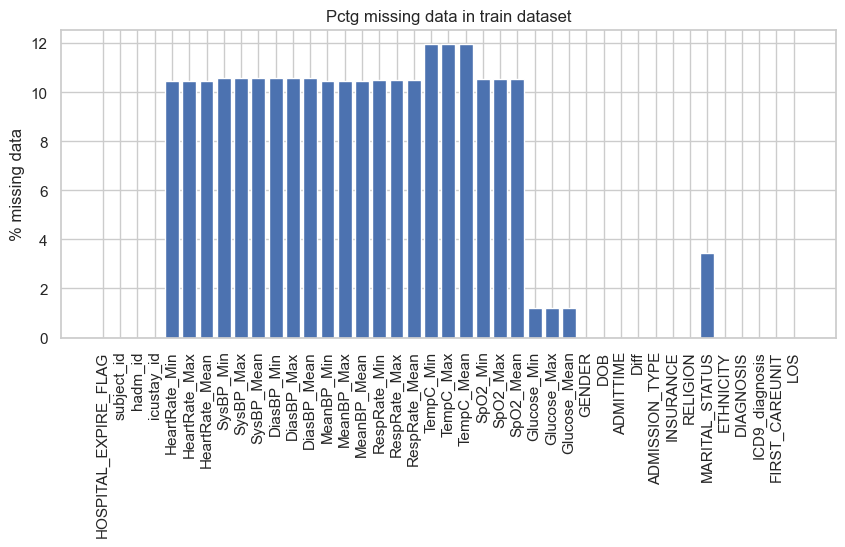

In [143]:
plt.figure(figsize=(10,4))
plt.xticks(rotation='vertical')
plt.bar(x_vals_train, y_vals_train)
plt.ylabel('% missing data')
plt.title('Pctg missing data in train dataset')
plt.show()

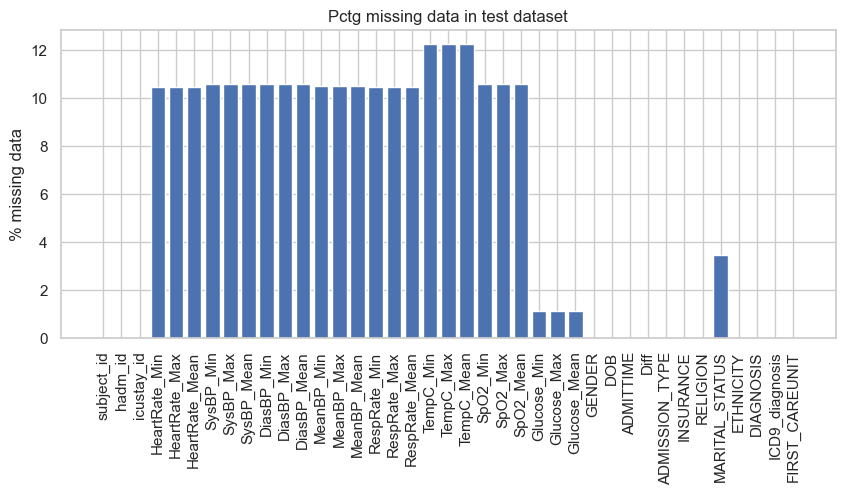

In [144]:
plt.figure(figsize=(10,4))
plt.xticks(rotation='vertical')
plt.bar(x_vals_test, y_vals_test)
plt.ylabel('% missing data')
plt.title('Pctg missing data in test dataset')
plt.show()


### 3. Data preprocessing

Before starting with the data prepocessing I define some functions that I use later for feature engineering.

In [145]:
# Helper functions

def get_age(df):
    df['Diff'] = df.apply(lambda x: timedelta(days=-x.Diff),axis=1)
    df['DOB'] = df.apply(lambda x: dt.datetime.strptime(x.DOB,'%Y-%m-%d %H:%M:%S'),axis=1)
    df['DOB'] = df.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
    df['ADMITTIME'] = df.apply(lambda x: dt.datetime.strptime(x.ADMITTIME,'%Y-%m-%d %H:%M:%S'),axis=1)
    df['ADMITTIME'] = df.apply(lambda x: (x.ADMITTIME.to_pydatetime() - x.Diff),axis=1)
    df['Age'] = df.apply(lambda x: ((x.ADMITTIME.to_pydatetime() - x.DOB.to_pydatetime()).days),axis=1)
    df['Age'] = df['Age'] / 365
    return df

def get_date(df):
    df['day'] = df['ADMITTIME'].apply(lambda x: x.day)
    df['month'] = df['ADMITTIME'].apply(lambda x: x.month)
    df['year'] = df['ADMITTIME'].apply(lambda x: x.year)
    df['hour'] = df['ADMITTIME'].apply(lambda x: x.hour)
    return df

def get_time(df):
    df['time_entrance']=np.where((df['hour'] > 22) | (df['hour'] < 6) , 'night', 'day')
    return df

def get_season(df):
    df['season'] = np.where((df['month'] > 11) | (df['month'] < 3) , 'winter', 'autumn')
    df['season'] = np.where((df['month'] > 2) & (df['month'] < 6) , 'spring', df['season'])
    df['season'] = np.where((df['month'] > 5) & (df['month'] < 9) , 'summer', df['season'])
    return df

def get_times_hospital(df):
    times_hospital = pd.DataFrame(df.subject_id.value_counts().reset_index())
    times_hospital.columns = ['subject_id', 'times_hospital']
    df = df.merge(times_hospital, on='subject_id', how='left')
    return df

def get_ethnicity(df):
    df.loc[df['ETHNICITY'].str.contains('WHITE'), 'ETHNICITY'] = 'WHITE'
    df.loc[df['ETHNICITY'].str.contains('BLACK'), 'ETHNICITY'] = 'BLACK'
    df.loc[df['ETHNICITY'].str.contains('AFRICAN'), 'ETHNICITY'] = 'BLACK'
    df.loc[df['ETHNICITY'].str.contains('HISPANIC'), 'ETHNICITY'] = 'LATINO'
    df.loc[df['ETHNICITY'].str.contains('LATINO'), 'ETHNICITY'] = 'LATINO'
    df.loc[df['ETHNICITY'].str.contains('ASIAN'), 'ETHNICITY'] = 'ASIAN'
    df.loc[df['ETHNICITY'].str.contains('UNABLE'), 'ETHNICITY'] = 'UNKNOWN'
    df.loc[df['ETHNICITY'].str.contains('SPECIFIED'), 'ETHNICITY'] = 'UNKNOWN'
    df.loc[df['ETHNICITY'].str.contains('DECLINED'), 'ETHNICITY'] = 'UNKNOWN'
    df.loc[~df['ETHNICITY'].isin(['WHITE', 'BLACK', 'LATINO','ASIAN','UNKNOWN']), 'ETHNICITY'] = 'OTHER'
    return df

def get_religion(df):
    df.loc[df['RELIGION'].str.contains('CATHOLIC'), 'RELIGION'] = 'CATHOLIC'
    df.loc[df['RELIGION'].str.contains('SPECIFIED'), 'RELIGION'] = 'NOT SPECIFIED'
    df.loc[df['RELIGION'].str.contains('JEWISH'), 'RELIGION'] = 'JEWISH'
    df.loc[df['RELIGION'].str.contains('UNOBTAINABLE'), 'RELIGION'] = 'UNOBTAINABLE'
    df.loc[~df['RELIGION'].isin(['CATHOLIC','NOT SPECIFIED','JEWISH','UNOBTAINABLE']), 'RELIGION'] = 'OTHER'
    return df

#### 3.1. Feature engineering
#### 3.1.1. Age


There are some variables that allow us to create an Age variable in both sets, that could be useful for prediction.

In [146]:
# Create age variable

df_train = get_age(df_train)
df_test = get_age(df_test)

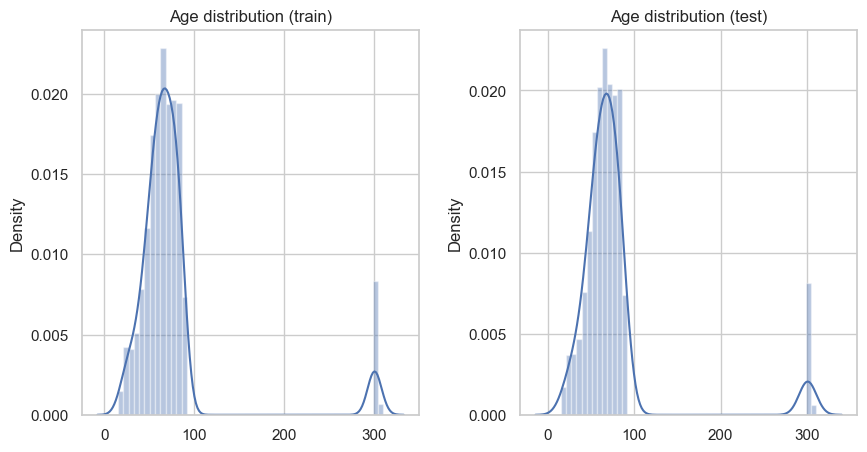

In [147]:
# Age distribution

fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(wspace=0.3)
sns.distplot(x=df_train["Age"], ax=axes[0])
axes[0].set_title("Age distribution (train)")
sns.distplot(x=df_test["Age"], ax=axes[1])
axes[1].set_title("Age distribution (test)")

plt.show()

Distribution plots show that there are some outliers observations above 100 years. According to the MIMIC III clinical database description:

"Dates of birth for patients aged over 89 were shifted to obscure their true age and comply with HIPAA regulations: these patients appear in the database with ages of over 300 years."

Therefore, I decided to replace all the observations above 89 years with NaN and then impute them. 

In [148]:
df_train.loc[df_train['Age'] > 89, 'Age'] = np.nan
df_test.loc[df_test['Age'] > 89, 'Age'] = np.nan

#### 3.1.2. Date, season and number of entries

Below I split the time and date of admission into different variables. Then I create a seasonal variable, which indicates in which season of the year the patient enters. Finally, I create a variable that indicates the number of times the person has been admitted. These features are created in order to obtain more information from the available data that can be useful for prediction.

In [149]:
# Create day, month, year, hour

df_train = get_date(df_train)
df_test = get_date(df_test)

In [150]:
# Create season

df_train = get_season(df_train)
df_test = get_season(df_test)

In [151]:
# Create number of entries

df_train = get_times_hospital(df_train)
df_test = get_times_hospital(df_test)

#### 3.1.3. Comorbidities and diagnoses

The diagnosis extra dataset has data about the different comorbidities of each patient. Since this information can be useful for prediction, I included a variable that represents the number of comorbidities of each patient.

In [152]:
# Get variable

comorbidities = extra.groupby(["subject_id", "hadm_id"]).max()["seq_num"].reset_index()
comorbidities = comorbidities.rename({"seq_num": "number_comorbidities"}, axis=1)
comorbidities

subject_id  hadm_id  number_comorbidities
0               2   163353                   3.0
1               3   145834                   9.0
2               4   185777                   9.0
3               5   178980                   3.0
4               6   107064                   8.0
...           ...      ...                   ...
58971       99985   176670                  13.0
58972       99991   151118                  17.0
58973       99992   197084                  12.0
58974       99995   137810                  17.0
58975       99999   113369                   5.0

[58976 rows x 3 columns]

In [153]:
# Merge df

df_train = pd.merge(df_train, comorbidities, left_on=["subject_id", "hadm_id"], right_on = ["subject_id", "hadm_id"], how = "left")
df_test = pd.merge(df_test, comorbidities, left_on=["subject_id", "hadm_id"], right_on = ["subject_id", "hadm_id"], how = "left")

In addition, I use the diagnoses dataset to calculate the probability of a patient having a certain comorbidity or combination of comorbidities based on the patient's ICD-9 diagnosis codes and length of stay in the ICU. The target encoder is used to transform the diagnosis codes into posterior probabilities, which are then used in further calculations to identify comorbidity combinations and their associated probabilities (mean, max, min). This information could be useful to predict the LOS.

In [154]:
# Merge df

diagnosis_train = df_train[['hadm_id', 'LOS']].merge(extra[['hadm_id' , 'icd9_code']], how='left', on=['hadm_id', ]).set_index('hadm_id')
diagnosis_test = df_test[['hadm_id' ]].merge(extra[['hadm_id','icd9_code']], how='left', on=['hadm_id' ,]).set_index('hadm_id' )

# Encode posterior probability

te = TargetEncoder(smoothing=1.0)
diagnosis_train_data = te.fit_transform(X=diagnosis_train[['icd9_code']], y=diagnosis_train.LOS).rename(columns={"icd9_code":"posterior_proba"})
diagnosis_test_data = te.transform(X=diagnosis_test[['icd9_code']])

# Aggregate by diagnosis

diagnosis_df = pd.concat([diagnosis_train_data, diagnosis_train.icd9_code], axis=1).merge(diagnosis[['icd9_code','long_diagnose']], on='icd9_code', 
            how='left' ).reset_index(level=0).groupby('icd9_code').agg({'posterior_proba':'first','index':'count', 'long_diagnose':'first'}).rename(columns={'index':'hadam_id_count'})

In [155]:
# Comorbidities combinations

comorbidities_train = (df_train[['hadm_id', 'LOS']]
            .merge(extra[['hadm_id' , 'icd9_code']], how='left', on=['hadm_id', ])
            .merge(diagnosis[['icd9_code','long_diagnose']], on ='icd9_code')
            .groupby('hadm_id', as_index=False)
                    .agg({'icd9_code': lambda x: list(combinations(x, 2)),
                        'long_diagnose': lambda x: list(combinations(x, 2)),
                        'LOS': 'first'})
                    .explode(['icd9_code',  'long_diagnose'])
                ).set_index('hadm_id')

comorbidities_test = (df_test[['hadm_id']]
            .merge(extra[['hadm_id' , 'icd9_code']], how='left', on=['hadm_id'])
            .merge(diagnosis[['icd9_code','long_diagnose']], on ='icd9_code')
            .groupby('hadm_id', as_index=False)
                    .agg({'icd9_code': lambda x: list(combinations(x, 2)),
                        'long_diagnose': lambda x: list(combinations(x, 2))})
                    .explode(['icd9_code',  'long_diagnose'])
                ).set_index('hadm_id')



In [156]:
# Encode posterior probability for each combination

cbe = TargetEncoder(smoothing=1.0)
comorbid_train_data = cbe.fit_transform(X=comorbidities_train[['icd9_code']], y=comorbidities_train.LOS).rename({'icd9_code':'posterior_proba'}, axis=1)
comorbid_test_data = cbe.transform(X=comorbidities_test[['icd9_code']]).rename({'icd9_code':'posterior_proba'}, axis=1)

comorbid_train_data = comorbid_train_data.rename({'posterior_proba':'comorbid'}).groupby(['hadm_id']).agg({ 'max', 'mean', 'min'})
comorbid_test_data = comorbid_test_data.rename({'posterior_proba':'comorbid'}).groupby(['hadm_id']).agg({'max', 'mean','min'})

comorbid_train_data.columns = ['_'.join(col).strip() for col in comorbid_train_data.columns.values]
comorbid_test_data.columns = ['_'.join(col).strip() for col in comorbid_test_data.columns.values]

# Merge df with final features

df_train = df_train.merge(comorbid_train_data, on=['hadm_id'], how='left')
df_test = df_test.merge(comorbid_test_data, on=['hadm_id'], how='left')

#### 3.1.3. Religion, Ethnicity and Marital Status

Below ethnicity and religion variables are simplified to have fewer categories that in turn are more representative.

In [157]:
# Create religion

df_train = get_religion(df_train)
df_test = get_religion(df_test)

In [158]:
# Create ethnicity

df_train = get_ethnicity(df_train)
df_test = get_ethnicity(df_test)

Finally, I fill the missing values of Marital Satus with the category "UNKNOWN".

In [159]:
# Replace missing values of marital status

df_train['MARITAL_STATUS'] = df_train['MARITAL_STATUS'].fillna('UNKNOWN')
df_test['MARITAL_STATUS'] = df_test['MARITAL_STATUS'].fillna('UNKNOWN')

#### 3.2. Cleaning features

In [160]:
# Create df copy

df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [161]:
# Removing unnecessary ID variables and features used to create new features

df_train_copy = df_train_copy.drop(['HOSPITAL_EXPIRE_FLAG','subject_id', 'hadm_id','ADMITTIME', 'DOB','Diff',
                          'DIAGNOSIS','ICD9_diagnosis',"icustay_id"], axis = 1)
df_test_copy = df_test_copy.drop(['subject_id', 'hadm_id','ADMITTIME', 'DOB','Diff',
                          'DIAGNOSIS','ICD9_diagnosis',"icustay_id"], axis = 1)

#### 3.3. Correlations

In [162]:
corr_matrix = df_train_copy.corr(numeric_only=True)
corr_matrix["LOS"].sort_values(ascending=False)

LOS                     1.000000
posterior_proba_max     0.437387
posterior_proba_mean    0.425520
number_comorbidities    0.335002
TempC_Max               0.164657
RespRate_Max            0.159270
HeartRate_Max           0.150670
RespRate_Mean           0.141701
posterior_proba_min     0.124009
HeartRate_Mean          0.116884
TempC_Mean              0.106119
MeanBP_Max              0.081008
HeartRate_Min           0.079271
SysBP_Max               0.068940
SpO2_Max                0.067647
Glucose_Max             0.066877
Glucose_Mean            0.048248
SpO2_Mean               0.039658
year                    0.033141
times_hospital          0.030550
DiasBP_Max              0.027848
Age                     0.026293
RespRate_Min            0.015433
month                   0.012555
day                    -0.003875
hour                   -0.008175
MeanBP_Mean            -0.020409
TempC_Min              -0.020681
Glucose_Min            -0.027488
SysBP_Mean             -0.048819
SpO2_Min  

After performing the feature engineering process, I recalculated the correlations of the features with LOS. I attempted to remove the variables that were less correlated, but this did not lead to an improvement in the models' performance. Therefore, I keep all of them.

#### 3.4. Pipeline

Below I define a pipeline to preprocess the data before training the models. I use the ColumnTransformer to allow for different data preprocessing for different types of columns (numeric and categorical). For the numeric columns, I use the k nearest neighbors (5 in this case) through KNNImputer in order to impute missing values of a patient. The strategy is to replace a missing value of a specific feature of a given patient A using the records of the set of patients that resemble the most patient A in other recorded features. In other words, imputing missing values by similarity. This imputer has been chosen because imputes an accurate estimate of the missing values without requiring as much information about the source of the missing values. Other imputers such as SimplerImputer (with mean and median) and IterativeImputer were tested, but using KNN a better performance was achieved.

For categorical columns, CatBoostEncoder is used to transform categorical features into numerical representations that can be used by the models. Other encoders, such as BinaryEncoder, were tested, but using CatBoost a better performance was achieved.

Finally, for both numeric and categorial columns, I use StandardScaler() to standardize the features.

In [163]:
y_train = df_train_copy['LOS']
df_train_copy = df_train_copy.drop(['LOS'],axis = 1)

In [164]:
# Define numeric and categorial features

num_feat=[name for name in df_train_copy.select_dtypes(include=np.number).columns]
cat_feat=[name for name in df_train_copy.select_dtypes(exclude=np.number).columns]

In [165]:
# Define numeric and categorical transformer

numeric_transformer = Pipeline(steps=[
       ('imputer', KNNImputer(missing_values=np.nan,
                                       weights = 'distance',
                                       add_indicator = False)),
      ('scaler', StandardScaler())   
])

categorical_transformer = Pipeline(steps=[
       ('encoder', CatBoostEncoder()),
       ('scaler', StandardScaler())
])

In [166]:
# Create columns transformer to apply the different transformers

preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, num_feat),
    ('categorical', categorical_transformer, cat_feat)
]) 

# Define the pipeline with the preprocessor

cleaning_pipeline = Pipeline(steps = [('preprocessor', preprocessor)])

In [167]:
# Use pipeline to preprocess the training and test data

X_train = cleaning_pipeline.fit_transform(df_train_copy,y_train)
X_test = cleaning_pipeline.transform(df_test_copy)


In [168]:
# Create dataframe with transformed train and test

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [169]:
# Recover feature names

variables = num_feat + preprocessor.transformers_[1][1]['encoder'].get_feature_names()
X_train.columns = variables

variables = num_feat + preprocessor.transformers_[1][1]['encoder'].get_feature_names()
X_test.columns = variables

In [170]:
# Checking common features

print("Features in train data but not in test:")
print(X_train.columns.difference(X_test.columns) )

print("\nFeatures in test data but not in train:")
print(X_test.columns.difference(X_train.columns) )

Features in train data but not in test:
Index([], dtype='object')

Features in test data but not in train:
Index([], dtype='object')


In [171]:
print(X_train.shape)
print(X_test.shape)

(20885, 42)
(5221, 42)


### 4. Models

Because defining a pipeline for each model is more time-consuming, the transformation of variables was performed prior to training the models.

In [172]:
SEED = 4

#### 4.1. Decision trees

The decision tree regressor model uses the 'squared_error' criterion for splitting nodes. A grid search to find the best hyperparameters for the model is used. Different values for the parameters has been tested during hyperparameter tuning. One important parameter of this grid is the max_leaf_nodes that can help to avoid overfitting.

The grid search uses cross-validation and parallel processing to evaluate different hyperparameter combinations. 

The best hyperparameters and corresponding cross-validation score are printed.

In [175]:
# Model
dt = DecisionTreeRegressor(criterion='squared_error')

# Grid
params_dt = [{
                'min_impurity_decrease': [0.01, 0.05, 0.1],
                'max_leaf_nodes': [20, 50, 100],
                'min_samples_leaf': [15, 20, 30],
                'min_samples_split': [1, 2 , 3],
                'random_state': [SEED]
            }]

grid_dt = GridSearchCV(dt, param_grid = params_dt, scoring = 'neg_mean_squared_error', cv = 2, verbose = 3, n_jobs=-1)

grid_dt.fit(X_train, y_train)

Fitting 2 folds for each of 81 candidates, totalling 162 fits


GridSearchCV(cv=2, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid=[{'max_leaf_nodes': [20, 50, 100],
                          'min_impurity_decrease': [0.01, 0.05, 0.1],
                          'min_samples_leaf': [15, 20, 30],
                          'min_samples_split': [1, 2, 3],
                          'random_state': [4]}],
             scoring='neg_mean_squared_error', verbose=3)

In [176]:
print("Best parameter (CV score=%0.3f):" % grid_dt.best_score_)
print(grid_dt.best_params_)

Best parameter (CV score=-18.184):
{'max_leaf_nodes': 50, 'min_impurity_decrease': 0.05, 'min_samples_leaf': 30, 'min_samples_split': 1, 'random_state': 4}


#### 4.2. Random Forest

The hyperparameters of the Random Forest Regressor model are tuned using a halving grid search cross-validation method because it is less time-consuming compared to grid search cross-validation. Different values for the parameters have been tested during hyperparameter tuning. The parameters max_depth, min_samples_leaf and min_samples_split can help to prevent overfitting and improve the generalization ability of the model.

The best hyperparameters and corresponding cross-validation score are printed.

In [92]:
# Model
rf = RandomForestRegressor()

# Grid
params_rf = [{
            'bootstrap': [True, False],
            'n_estimators': [75, 100, 120],
            'max_depth': [20, 25, 35],
            'min_samples_leaf': [1, 5, 7],
            'min_samples_split': [1, 2],
            'random_state': [SEED]
            }]

grid_rf = HalvingGridSearchCV(rf, param_grid = params_rf, scoring = 'neg_mean_squared_error', cv = 2, verbose = 3, n_jobs=-1)

grid_rf.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 257
max_resources_: 20885
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 257
Fitting 2 folds for each of 108 candidates, totalling 216 fits
----------
iter: 1
n_candidates: 36
n_resources: 771
Fitting 2 folds for each of 36 candidates, totalling 72 fits
----------
iter: 2
n_candidates: 12
n_resources: 2313
Fitting 2 folds for each of 12 candidates, totalling 24 fits
----------
iter: 3
n_candidates: 4
n_resources: 6939
Fitting 2 folds for each of 4 candidates, totalling 8 fits
----------
iter: 4
n_candidates: 2
n_resources: 20817
Fitting 2 folds for each of 2 candidates, totalling 4 fits


HalvingGridSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=-1,
                    param_grid=[{'bootstrap': [True, False],
                                 'max_depth': [20, 25, 35],
                                 'min_samples_leaf': [1, 5, 7],
                                 'min_samples_split': [1, 2],
                                 'n_estimators': [75, 100, 120],
                                 'random_state': [4]}],
                    scoring='neg_mean_squared_error', verbose=3)

In [93]:
print("Best parameter (CV score=%0.3f):" % grid_rf.best_score_)
print(grid_rf.best_params_)

Best parameter (CV score=-15.907):
{'bootstrap': True, 'max_depth': 35, 'min_samples_leaf': 7, 'min_samples_split': 1, 'n_estimators': 120, 'random_state': 4}


In [49]:
# Model with best parameters 

rf_opt = RandomForestRegressor(bootstrap=True,max_depth=35, min_samples_leaf=7, min_samples_split=1, n_estimators=120, random_state=SEED)

#### 4.3. Adaptive Boosting

The Adaptive Boosting Regressor model uses DecisionTreeRegressor() as base estimator, that can be good if the data has non-linear relationships between the features and the target variable. The hyperparameters of the model are tuned using a halving grid search cross-validation method because it is less time-consuming compared to grid search cross-validation. Different values for the parameters have been tested during hyperparameter tuning. 

The best hyperparameters and corresponding cross-validation score are printed.

In [86]:
# Model
ab = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())

# Grid
params_ab = [{
                'learning_rate': [0.5, 1.0, 1.5],
                'n_estimators': [500, 1000, 1500],
                'random_state': [SEED]
            }]

grid_ab = HalvingGridSearchCV(ab, param_grid = params_ab, scoring = 'neg_mean_squared_error', cv = 2, verbose = 3, n_jobs=-1)

grid_ab.fit(X_train, y_train)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2320
max_resources_: 20885
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 2320
Fitting 2 folds for each of 18 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 6
n_resources: 6960
Fitting 2 folds for each of 6 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 20880
Fitting 2 folds for each of 2 candidates, totalling 4 fits


HalvingGridSearchCV(cv=2,
                    estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),
                    n_jobs=-1,
                    param_grid=[{'learning_rate': [0.01, 0.1, 0.5, 1.0, 2.0,
                                                   5.0],
                                 'n_estimators': [200, 500, 1000],
                                 'random_state': [4]}],
                    scoring='neg_mean_squared_error', verbose=3)

In [87]:
print("Best parameter (CV score=%0.3f):" % grid_ab.best_score_)
print(grid_ab.best_params_)

Best parameter (CV score=-17.168):
{'learning_rate': 1.0, 'n_estimators': 1000, 'random_state': 4}


In [48]:
# Model with best parameters 

ab_opt = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), learning_rate=1.0, n_estimators=1000, random_state=SEED)

#### 4.4. XG Boost Regressor

XGBoost is a software library that enables the application of gradient boosting algorithms. This type of ensemble model aggregates the predictions of multiple weak models to produce a robust prediction. An important distinction between XGBoost and AdaBoost is that XGBoost employs decision tree models as the base models, whereas AdaBoost can incorporate any type of base model.

A halving grid search with cross-validation to tune the hyperparameters of model is used. The hyperparameters being tuned are the learning rate, maximum depth, and number of estimators, subsample and colsample bytree. 

The best hyperparameters and corresponding cross-validation score are printed.

In [95]:
# Pipeline
xg = XGBRegressor(objective='reg:squarederror')

# Grid
params_xg = [{
            'learning_rate': [0.01, 0.03],
            'max_depth': [1, 3, 5, 7, 9],
            'n_estimators': [100, 250, 300, 350],
            'learning_rate': [0.01, 0.1, 0.5],
            'subsample': [0.6, 0.8],
            'colsample_bytree': [0.5, 0.8],
            }]

grid_xg = HalvingGridSearchCV(xg, param_grid = params_xg, scoring = 'neg_mean_squared_error', cv = 2, verbose = 3, n_jobs=-1)

grid_xg.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 257
max_resources_: 20885
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 240
n_resources: 257
Fitting 2 folds for each of 240 candidates, totalling 480 fits
----------
iter: 1
n_candidates: 80
n_resources: 771
Fitting 2 folds for each of 80 candidates, totalling 160 fits
----------
iter: 2
n_candidates: 27
n_resources: 2313
Fitting 2 folds for each of 27 candidates, totalling 54 fits
----------
iter: 3
n_candidates: 9
n_resources: 6939
Fitting 2 folds for each of 9 candidates, totalling 18 fits
----------
iter: 4
n_candidates: 3
n_resources: 20817
Fitting 2 folds for each of 3 candidates, totalling 6 fits


HalvingGridSearchCV(cv=2,
                    estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                    n_jobs=-1,
                    param_grid=[{'colsample_bytree': [0.5, 0.8],
                                 'learning_rate': [0.01, 0.1, 0.5],
                                 'max_depth': [1, 3, 5, 7, 9],
                                 'n_estimators': [100, 250, 300, 350],
                                 'subsample': [0.6, 0.8]}],
                    scoring='neg_mean_squared_error', verbose=3)

In [96]:
print("Best parameter (CV score=%0.3f):" % grid_xg.best_score_)
print(grid_xg.best_params_)

Best parameter (CV score=-16.178):
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 250, 'subsample': 0.8}


In [47]:
# Model with best parameters 

xg_opt = XGBRegressor(objective='reg:squarederror',colsample_bytree=0.8, learning_rate= 0.01, max_depth=7, n_estimators=250, subsample=0.8)

#### 4.5. Neural Network

The neural network regression model is built using the Keras library from TensorFlow. The neural network is defined using the Sequential model from Keras, which consists of a linear stack of layers. The model consists of two layers: a dense layer with 16 neurons and a rectified linear unit (ReLU) activation function, and a dense layer with a single output unit and a linear activation function. The first layer also includes a regularization term using L1 and L2 regularization. These regularizations work by adding a penalty term to the loss function of the model that encourages it to have smaller weights. This helps to prevent overfitting by reducing the complexity of the model and forcing it to focus on the most important features in the data.

The model is compiled using the mean squared error loss function and the Adam optimizer. This optimizer dynamically adjusts the learning rate during training by computing an adaptive learning rate for each parameter based on the estimation of the first and second moments of the gradients. This adaptive learning rate allows for better convergence and is particularly useful when dealing with large datasets and complex models.

The cross_val_score function is used to evaluate the model using cross-validation with the KFold strategy defined earlier.

In [68]:
# Define model

def build_model():
    model = Sequential()
    model.add(Dense(units=16, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001), input_dim=X_train.shape[1]))
    model.add(Dense(units=1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

nn = KerasRegressor(build_fn=build_model, batch_size=128, epochs=100)
kfold = KFold(n_splits=5, random_state=SEED, shuffle=True)
results = cross_val_score(nn, X_train, y_train, cv=kfold)
history = nn.fit(X_train, y_train)

Epoch 1/100
131/131 [==============================] - 1s 2ms/step - loss: 38.0868
Epoch 2/100
131/131 [==============================] - 0s 2ms/step - loss: 25.9068
Epoch 3/100
131/131 [==============================] - 0s 3ms/step - loss: 21.7309
Epoch 4/100
131/131 [==============================] - 0s 2ms/step - loss: 20.0991
Epoch 5/100
131/131 [==============================] - 0s 2ms/step - loss: 19.2631
Epoch 6/100
131/131 [==============================] - 0s 2ms/step - loss: 18.7697
Epoch 7/100
131/131 [==============================] - 0s 2ms/step - loss: 18.4373
Epoch 8/100
131/131 [==============================] - 0s 2ms/step - loss: 18.1076
Epoch 9/100
131/131 [==============================] - 0s 2ms/step - loss: 17.8378
Epoch 10/100
131/131 [==============================] - 0s 1ms/step - loss: 17.5903
Epoch 11/100
131/131 [==============================] - 0s 2ms/step - loss: 17.3791
Epoch 12/100
131/131 [==============================] - 0s 2ms/step - loss: 17.2051
E

In [69]:
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -16.25 (1.93) MSE


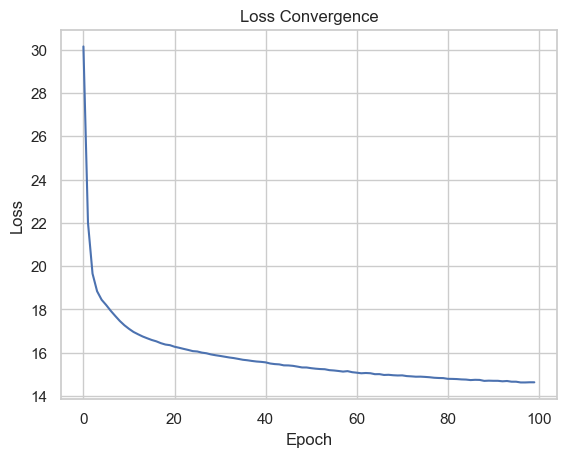

In [70]:
# Plot convergence

plt.plot(history.history['loss'])
plt.title('Loss Convergence')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Here I plot the training loss to check that the training algorithm has converged. 

In [128]:
# Predictions of the models

y_hat_dt = grid_dt.predict(X_test)
y_hat_rf = grid_rf.predict(X_test)
y_hat_ab = grid_ab.predict(X_test)
y_hat_xg = grid_xg.predict(X_test)
y_hat_nn = nn.predict(X_test)

41/41 [==============================] - 0s 837us/step


In [131]:
# Produce .csv for kaggle testing 

DT_test_predictions_submit = pd.DataFrame({"icustay_id": df_test["icustay_id"], "LOS": y_hat_rf})
DT_test_predictions_submit.to_csv("Test_predictions_submit_rf.csv", index = False)

#### 4.6. Ensembles

##### 4.6.1. Stacking ensemble with feature propagation

The structure of this stacking ensamble consists in two levels of learners: base and meta algorithms. The base learners are XGBoost, RandomForest and AdaBoost. The meta learner is ExtraTreesRegressor. In addition, we propagate features to the superlearner, to avoid only having results of previous models. The selected features are the most important according to RandomForest, which is the model that has the best performance.

The Super Learner algorithm works by training the multiple base models on the training data, and then using the meta-learner to combine their predictions into a final prediction. In case it is performing 2-fold cross-validation.

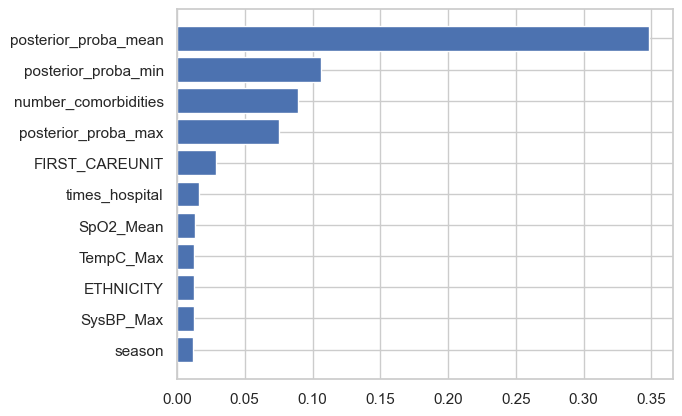

Index(['number_comorbidities', 'posterior_proba_min', 'posterior_proba_max',
       'posterior_proba_mean', 'FIRST_CAREUNIT'],
      dtype='object')

In [125]:
# Feature propagation

def feature_imp(coef, names):
    imp = coef
    indexes = np.argsort(imp)[-11:]
    indexes = list(indexes)
    
    plt.barh(range(len(indexes)), imp[indexes], align='center')
    plt.yticks(range(len(indexes)), [names[i] for i in indexes])
    plt.show()
    
    return indexes

features_d = X_train.columns
opt = rf_opt.fit(X_train, y_train)
feat_indexes = feature_imp(abs(opt.feature_importances_), features_d)
feat_to_prop = [features_d[i] for i in feat_indexes][-5:]
pointer = [i for i, feat in enumerate(features_d) if feat in feat_to_prop]
X_train.columns[pointer]

In [130]:
# Base model
models = [ab_opt, xg_opt, rf_opt]

# Meta learner

meta_learner = ExtraTreesRegressor(random_state=SEED)

# Super Learner

sl = SuperLearner(
    folds=2,
    random_state=SEED,
    verbose=3,
    backend="multiprocessing",
)

# Add the base learners and the meta learner
sl.add(models, propagate_features=pointer)
sl.add_meta(meta_learner)

# Train the ensemble
sl.fit(X_train.values, y_train)

# Predict the test set
y_hat_sl = sl.predict(X_test.values)


Fitting 2 layers
Processing layer-1            
Learners ...                   done | 00:13:08
layer-1                        done | 00:13:11
Processing layer-2            
Learners ...                   done | 00:00:05
layer-2                        done | 00:00:05
Fit complete                        | 00:13:18

Predicting 2 layers
Processing layer-1            
Learners ...                   done | 00:00:12
layer-1                        done | 00:00:12
Processing layer-2            
Learners ...                   done | 00:00:01
layer-2                        done | 00:00:01
Predict complete                    | 00:00:15


In [133]:
# save my model
filename = 'stacking_model1.sav'
pickle.dump(sl, open(filename, 'wb'))
 
# check load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.predict(X_test.values)


Predicting 2 layers
Processing layer-1            
Learners ...                   done | 00:00:23
layer-1                        done | 00:00:23
Processing layer-2            
Learners ...                   done | 00:00:03
layer-2                        done | 00:00:03
Predict complete                    | 00:00:28


array([3.566384, 7.320991, 2.815211, ..., 2.302943, 2.186972, 1.56285 ],
      dtype=float32)

##### 4.6.2. Stacking ensemble with Lasso

In this second ensemble model, I used Lasso as the meta-learner model instead of ExtraDecisionTrees, as Lasso has useful properties for feature selection and regularization.

In [122]:
from sklearn.linear_model import Lasso

# Base models

models = [ab_opt, xg_opt, rf_opt]

# Meta learner

meta_learner = Lasso(alpha=0.01)

# Super learner

sl_la_o = SuperLearner(
    folds=2,
    random_state=SEED,
    verbose=3,
    backend="multiprocessing",
)

# Add the base learners and the meta learner
sl_la_o.add(models)
sl_la_o.add_meta(meta_learner)

# Train the ensemble
sl_la_o.fit(X_train.values, y_train)

# Predict the test set
y_hat_la_o = sl_la_o.predict(X_test.values)


Fitting 2 layers
Processing layer-1            
Learners ...                   done | 00:12:42
layer-1                        done | 00:12:49
Processing layer-2            
Learners ...                   done | 00:00:00
layer-2                        done | 00:00:00
Fit complete                        | 00:12:50

Predicting 2 layers
Processing layer-1            
Learners ...                   done | 00:00:12
layer-1                        done | 00:00:12
Processing layer-2            
Learners ...                   done | 00:00:00
layer-2                        done | 00:00:00
Predict complete                    | 00:00:14


In [53]:
# save my model
filename = 'stacking_model_lasso.sav'
pickle.dump(sl, open(filename, 'wb'))
 
# check load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.predict(X_test.values)


Predicting 2 layers
Processing layer-1            
Learners ...                   done | 00:00:13
layer-1                        done | 00:00:13
Processing layer-2            
Learners ...                   done | 00:00:00
layer-2                        done | 00:00:00
Predict complete                    | 00:00:15


array([3.4085703, 6.731222 , 3.430384 , ..., 2.111227 , 2.3275573,
       1.5054529], dtype=float32)

In [123]:
# Produce .csv for kaggle testing 

DT_test_predictions_submit = pd.DataFrame({"icustay_id": df_test["icustay_id"], "LOS": y_hat_la_o})
DT_test_predictions_submit.to_csv("Test_predictions_submit_lao.csv", index = False)

The ensemble model using Lasso as the meta-learner had the best performance out of all the models.

#### 4.7. Model interpretability

#### 4.7.1. Neural Network Regressor Model

For the Neural Network model interpretability I use shap.DeepExplainer to address global explanation of the test set. Due to time constraints the global explanation of the train set could not be checked.

In [96]:
import shap

# Define the Shap Explainer

explainer = shap.DeepExplainer(nn.model, X_train.values)
shap_values = explainer.shap_values(X_test.values)

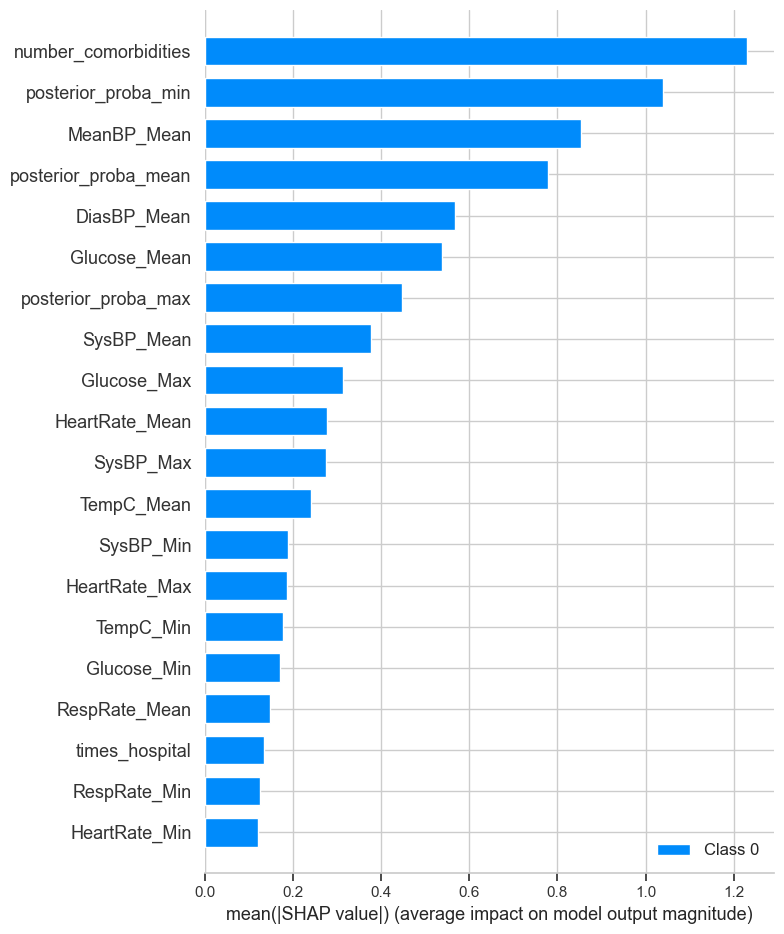

In [98]:
# Initialize the JS visualization
shap.initjs()

# Generate the SHAP summary plot for the test data 
shap.summary_plot(shap_values, X_test, plot_type="bar")

This plot summarize the most important features that contribute to the model's predictions, and how each feature impacts the prediction. The features that have stronger impact are number of comorbidites and posterior proba.

#### 4.7.2. Ensemble Model

For the Ensemble Model interpretability I use LIME.

In [119]:
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

# Define the Lime Explainer

explainer = LimeTabularExplainer(training_data= X_train.values, feature_names= X_train.columns,
                                 mode='regression', training_labels=y_train)

In [125]:
instance = 1

exp = explainer.explain_instance(
    data_row = X_test.iloc[instance].values,
    predict_fn = sl_la_o.predict)

exp.show_in_notebook()


Predicting 2 layers
Processing layer-1            
Learners ...                   done | 00:00:08
layer-1                        done | 00:00:08
Processing layer-2            
Learners ...                   done | 00:00:00
layer-2                        done | 00:00:00
Predict complete                    | 00:00:09


In [126]:
instance = 20

exp = explainer.explain_instance(
    data_row = X_test.iloc[instance].values,
    predict_fn = sl_la_o.predict)

exp.show_in_notebook()


Predicting 2 layers
Processing layer-1            
Learners ...                   done | 00:00:08
layer-1                        done | 00:00:08
Processing layer-2            
Learners ...                   done | 00:00:00
layer-2                        done | 00:00:00
Predict complete                    | 00:00:09


LIME explainer can be used to check different instances.

I first select instance 1. The results shows that for this instance the predicted LOS value is 6.66. The variables posterior_proba_mean and posterior_proba_max have positive influence while number_comorbidites and first_careunit have negative influence on predicted LOS.

Then I select instance 20. The results shows that for this instance the predicted LOS value is 4.20. In this case, the variables posterior_proba_mean and number_comorbidites have positive influence while first_careunit and some variables corresponding to the vitals of the patient have negative influence on predicted LOS.

In conclusion, the impact of the features changes throughout the different instances.